In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from joblib import Parallel, delayed
import gudhi

# --- Parameters ---
window_size  = 10
stride       = 50
max_dim      = 2
epsilons     = np.linspace(0, 1.0, 30)

# --- Load + parse timestamp ---
df = pd.read_csv("timeMerged-400-botnet.csv", parse_dates=["timestamp"])

# --- Convert timestamp to numeric (seconds since epoch) for TDA ---
df["ts_sec"] = df["timestamp"].astype("int64") / 1e9

# --- Feature selection & scaling (drop the original timestamp) ---
features = ["ts_sec", "duration", "packets_count", "total_payload_bytes",
            "bytes_rate", "syn_flag_counts"]
X = StandardScaler().fit_transform(df[features].values)

# --- Betti curve computation ---
def betti_curve(window):
    rips = gudhi.RipsComplex(points=window, max_edge_length=epsilons[-1])
    st   = rips.create_simplex_tree(max_dimension=max_dim)
    st.compute_persistence()
    B = np.zeros((max_dim + 1, len(epsilons)), dtype=int)
    for d in range(max_dim + 1):
        for b, dth in st.persistence_intervals_in_dimension(d):
            i0, i1 = np.searchsorted(epsilons, [b, dth], side="left")
            if i1 > i0:
                B[d, i0:i1] += 1
    return B.flatten()

# --- Sliding windows ---
starts = list(range(0, len(X) - window_size + 1, stride))
print(f"Computing Betti curves over {len(starts)} windows…")

betti_features = np.array(
    Parallel(n_jobs=-1)(
        delayed(betti_curve)(X[i : i + window_size]) for i in starts
    )
)

# --- Anomaly detection ---
model  = IsolationForest(contamination=0.05, random_state=42)
model.fit(betti_features)
scores = -model.decision_function(betti_features)
labels = model.predict(betti_features)  # -1 = anomaly

# --- Align results with real timestamps for plotting ---
window_timestamps = df["timestamp"].iloc[starts].reset_index(drop=True)
df_plot = (
    pd.DataFrame({
        "timestamp": window_timestamps,
        "score":     scores,
        "anomaly":   (labels == -1).astype(int),
    })
    .set_index("timestamp")
)

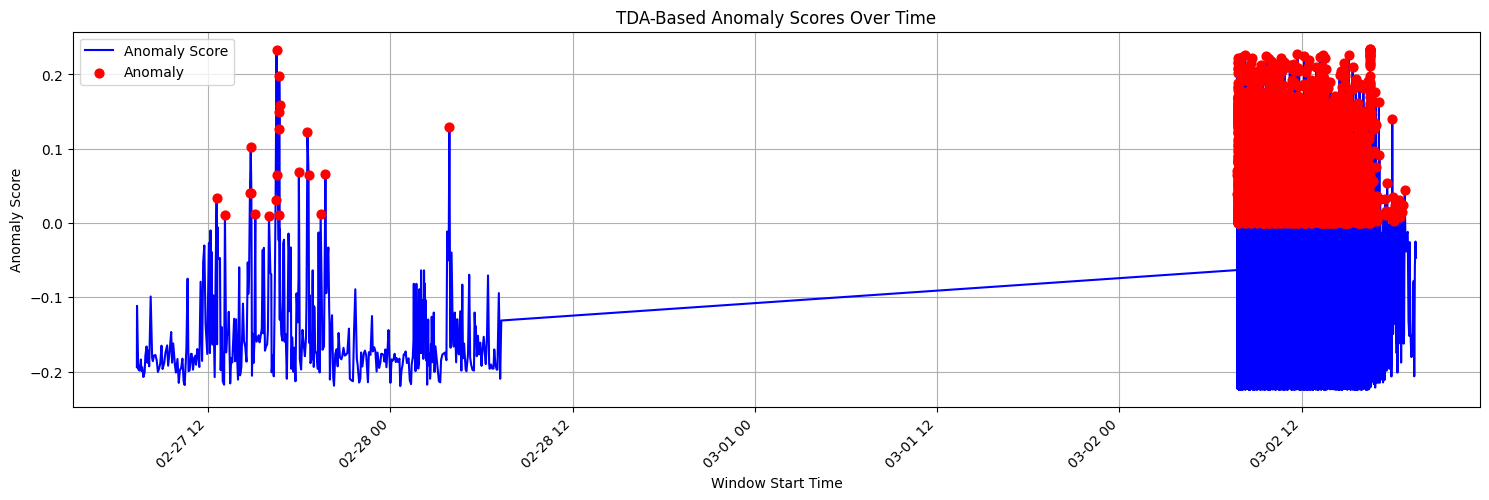

In [3]:
# --- Plot anomaly scores ---
plt.figure(figsize=(15, 5))
df_plot['score'].plot(label='Anomaly Score', color='blue')

# Overlay anomalies
anomalies = df_plot[df_plot['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['score'], color='red', label='Anomaly', s=40, zorder=5)

plt.title("TDA-Based Anomaly Scores Over Time")
plt.xlabel("Window Start Time")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [5]:
# --- Save output (optional) ---
anomalies.to_csv("detected_anomalies.csv")
print(f"{len(anomalies)} anomalies saved to detected_anomalies.csv.")

5136 anomalies saved to detected_anomalies.csv.


In [4]:
import matplotlib.pyplot as plt

# Select columns to plot
plot_cols = ['beta_0', 'beta_1', 'beta_2', 'deg_max', 'num_edges']

# Extract anomaly windows
anoms = normed[flags['anomaly']]

# Create plot
plt.figure(figsize=(18, 6))
normed[plot_cols].plot(ax=plt.gca(), linewidth=1.8)

# Red dots on anomalies (dot at highest metric per row)
plt.scatter(anoms.index,
            anoms[plot_cols].max(axis=1),
            color='red', s=40, label='anomaly', zorder=5)

# Beautify
plt.title("Normalised Betti Numbers & Graph Metrics — baseline anomalies")
plt.xlabel("Window start")
plt.ylabel("Normalised value (0–1)")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



KeyboardInterrupt

